In [1]:
import os
import yfinance as yf
import pandas as pd
import streamlit as st
import plotly.graph_objects as go
from datetime import datetime, timedelta
from sbi_access import get_sbi_holdings
from algo_trade import algo_trade
import csv
import requests
from io import StringIO
from dotenv import load_dotenv

import copy
import yfinance as yf
import pandas as pd
import numpy as np
import streamlit as st
import os
import requests
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from datetime import datetime, timedelta
from typing import List
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

2023-05-05 06:43:27.445 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [2]:
from s4_reg.core import s4regressor as regressor
from s4_reg.src_dataloaders_original import StandardScaler
from s4_reg.src_utils_visualize import prediction_result as post

c:\Users\rodin\work\stock_trade\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rodin\work\stock_trade\.venv\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


Informer

2023-05-01 22:22:18.994 INFO    s4_reg.core: Instantiating callback <s4_reg.src_callbacks_timer.Timer>
2023-05-01 22:22:18.997 INFO    s4_reg.core: Instantiating callback <s4_reg.src_callbacks_params.ParamsLog>
2023-05-01 22:22:18.998 INFO    s4_reg.core: Instantiating callback <pytorch_lightning.callbacks.EarlyStopping>
2023-05-01 22:22:19.001 INFO    s4_reg.core: Instantiating callback <pytorch_lightning.callbacks.ModelCheckpoint>
2023-05-01 22:22:19.300 INFO    s4_reg.src_models_sequence_ss_s4: Constructing S4 (H, N, L) = (1024, 64, 65)
2023-05-01 22:22:19.401 INFO    s4_reg.src_models_sequence_ss_s4: Constructing S4 (H, N, L) = (1024, 64, 65)
2023-05-01 22:22:19.416 INFO    s4_reg.src_models_sequence_ss_s4: Constructing S4 (H, N, L) = (1024, 64, 65)
2023-05-01 22:22:19.432 INFO    s4_reg.src_models_sequence_ss_s4: Constructing S4 (H, N, L) = (1024, 64, 65)
2023-05-01 22:22:19.639 INFO    s4_reg.core: Optimizer group 0 | 39 tensors


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

2023-05-01 22:22:23.758 INFO    s4_reg.src_models_sequence_ss_kernel: S4: Initializing kernel to length 65
2023-05-01 22:22:23.918 INFO    s4_reg.src_models_sequence_ss_kernel: S4: Initializing kernel to length 65
2023-05-01 22:22:24.036 INFO    s4_reg.src_models_sequence_ss_kernel: S4: Initializing kernel to length 65
2023-05-01 22:22:24.166 INFO    s4_reg.src_models_sequence_ss_kernel: S4: Initializing kernel to length 65


Epoch 2:  84%|████████▍ | 101/120 [01:04<00:12,  1.58it/s, loss=0.0311, val/mse=0.0805, val/loss=0.0805, train/mse=0.0347, train/loss=0.0347]


2023-05-01 22:25:42.539 INFO    s4_reg.src_models_sequence_ss_s4: Constructing S4 (H, N, L) = (1024, 64, 65)
2023-05-01 22:25:42.778 INFO    s4_reg.src_models_sequence_ss_s4: Constructing S4 (H, N, L) = (1024, 64, 65)
2023-05-01 22:25:42.910 INFO    s4_reg.src_models_sequence_ss_s4: Constructing S4 (H, N, L) = (1024, 64, 65)
2023-05-01 22:25:43.073 INFO    s4_reg.src_models_sequence_ss_s4: Constructing S4 (H, N, L) = (1024, 64, 65)


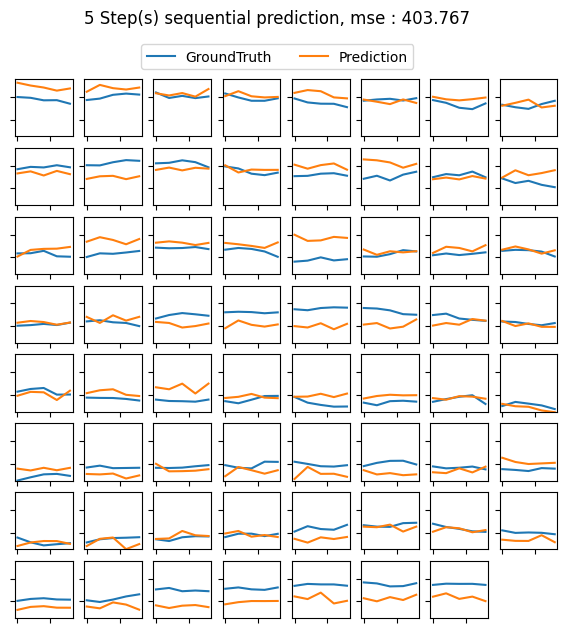

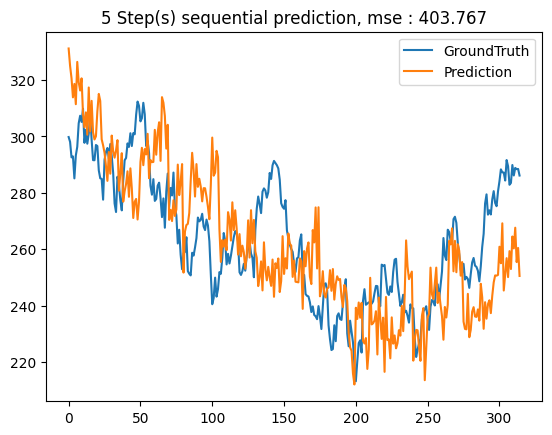

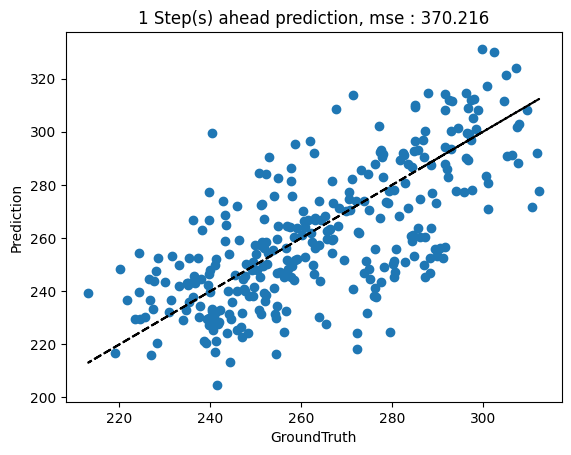

In [73]:
import pickle

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

seq_len, pred_len = 60, 5
df_train = data.iloc[:int(len(data)*0.7),:]
df_test  = data.iloc[int(len(data)*0.7):,:]

ckpt = 'null'
max_epochs = 10
batch_size = 10
features = 'S'
train_hippo = False
dropout = 0.4
d_state = 64
n_layers = 4
d_model = 1024
weight_decay = 0.98
lr = 0.001
valid_ratio = 0.125
patience = 3
loss_metric = 'mse'

# Standardize manually
scaler = {}
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()
for col in df_train.columns:
    if col != 'date':
        scaler[col] = StandardScaler()
        scaler[col].fit(data[col].values)
        df_train_scaled[col] = scaler[col].transform(df_train[col].values)
        df_test_scaled[col] = scaler[col].transform(df_test[col].values)
        
model = regressor(
    dataset = df_train_scaled,
    target = target,
    ckpt = ckpt,
    size = [seq_len, pred_len],
    max_epochs = max_epochs,
    batch_size = batch_size,
    features = features,
    train_hippo = train_hippo,
    dropout = dropout,
    n_layers = n_layers,
    d_state = d_state,
    d_model = d_model,
    lr = lr,
    weight_decay = weight_decay,
    patience = patience,
    valid_ratio = valid_ratio,
    loss_metric = loss_metric,
    device = 'cpu'
)

model.fit()

predictions = model.predict(
    df_test_scaled,
    forecast = True
)

for col in predictions.columns:
    predictions[col] = scaler[target].inverse_transform(predictions[col].values)

trained = post(
    df_test,
    predictions,
    target,
    loss_metric = loss_metric
)

fig_by_pred, _ = trained.val_by_pred(figsize=7)
fig_transition, loss = trained.val_transition()
fig_yy, _ = trained.val_yy(type="discrete")

LightGBM自己回帰

CUDA extension for Cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%
Falling back on slow Cauchy kernel. Install at least one of pykeops or the CUDA extension for memory efficiency.
Falling back on slow Vandermonde kernel. Install pykeops for improved memory efficiency.


Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.316945	valid_1's l2: 0.361449
[100]	training's l2: 0.166932	valid_1's l2: 0.237017
[150]	training's l2: 0.0891144	valid_1's l2: 0.165285
[200]	training's l2: 0.0491947	valid_1's l2: 0.122495
[250]	training's l2: 0.0277548	valid_1's l2: 0.0945298
[300]	training's l2: 0.0161152	valid_1's l2: 0.0774257
[350]	training's l2: 0.00969484	valid_1's l2: 0.0666198
[400]	training's l2: 0.00609356	valid_1's l2: 0.0591506
[450]	training's l2: 0.00395911	valid_1's l2: 0.0539411
[500]	training's l2: 0.00275723	valid_1's l2: 0.0502582
[550]	training's l2: 0.0019873	valid_1's l2: 0.0474066
[600]	training's l2: 0.0014997	valid_1's l2: 0.0452758
[650]	training's l2: 0.00117372	valid_1's l2: 0.0435655
[700]	training's l2: 0.000951071	valid_1's l2: 0.0423716
[750]	training's l2: 0.000784786	valid_1's l2: 0.0416374
[800]	training's l2: 0.00065584	valid_1's l2: 0.0410372
[850]	training's l2: 0.000555979	valid_1's l2: 0.0406633

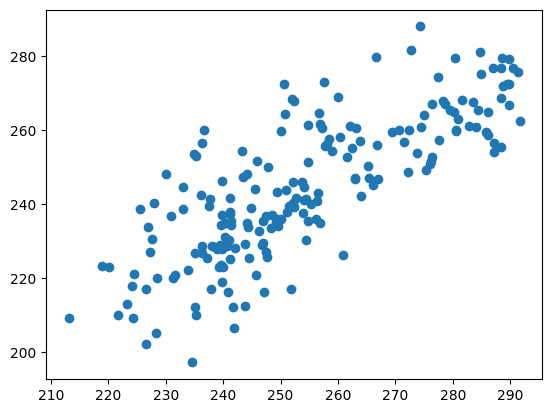

mse : 251.36695165955595


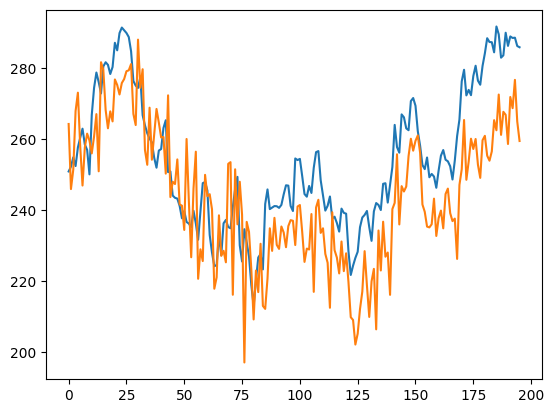

In [3]:
import pickle

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

seq_len, pred_len = 180, 1
df_train = data.iloc[:int(len(data)*0.7),:]
df_test  = data.iloc[int(len(data)*0.7):,:]

features = 'S'
d_model = 2048
loss_metric = 'mse'

# Standardize manually
scaler = {}
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()
for col in df_train.columns:
    if col != 'date':
        scaler[col] = StandardScaler()
        scaler[col].fit(data[col].values)
        df_train_scaled[col] = scaler[col].transform(df_train[col].values)
        df_test_scaled[col] = scaler[col].transform(df_test[col].values)
        
model = regressor(
    dataset = df_train_scaled,
    target = target,
    size = [seq_len, pred_len],
    features = features,
    d_model = d_model,
    device = 'cpu'
)

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

params = {
    'objective': 'regression',
    'metric': str(loss_metric),
    'boosting_type': 'gbdt',
    'num_leaves': 10,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': -1,
    'seed': 42
}

feat_df = model.get_features(df_train_scaled).iloc[:-1]
X_train, X_test, y_train, y_test = train_test_split(feat_df.drop([target], axis=1), feat_df[target], test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test)

lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=50
)

s4_ans = df_test[target].iloc[seq_len:]
s4_pred_data = model.get_features(df_test_scaled).drop([target], axis=1).iloc[:-1]
s4_pred = lgb_model.predict(s4_pred_data)
s4_pred = scaler[target].inverse_transform(s4_pred)

mse = mean_squared_error(s4_ans, s4_pred)
plt.scatter(s4_ans, s4_pred)
plt.show()
plt.plot(s4_ans.values)
plt.plot(s4_pred)
print(f'{loss_metric} : {mse}')

LightGBM自己回帰＋外生変数

Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.316198	valid_1's l2: 0.356763
[100]	training's l2: 0.166053	valid_1's l2: 0.233586
[150]	training's l2: 0.0887538	valid_1's l2: 0.163336
[200]	training's l2: 0.0489212	valid_1's l2: 0.122216
[250]	training's l2: 0.0275449	valid_1's l2: 0.0941248
[300]	training's l2: 0.0160516	valid_1's l2: 0.0776249
[350]	training's l2: 0.0096449	valid_1's l2: 0.0665255
[400]	training's l2: 0.00610738	valid_1's l2: 0.0589485
[450]	training's l2: 0.00400098	valid_1's l2: 0.0535376
[500]	training's l2: 0.00277841	valid_1's l2: 0.0499923
[550]	training's l2: 0.00202064	valid_1's l2: 0.0470923
[600]	training's l2: 0.00152186	valid_1's l2: 0.0451387
[650]	training's l2: 0.00119303	valid_1's l2: 0.0435012
[700]	training's l2: 0.000968361	valid_1's l2: 0.042489
[750]	training's l2: 0.000798867	valid_1's l2: 0.0418009
[800]	training's l2: 0.000672059	valid_1's l2: 0.0413192
[850]	training's l2: 0.000568962	valid_1's l2: 0.041004

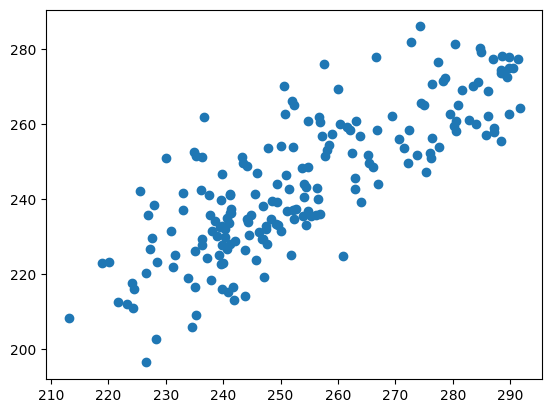

mse : 234.7839076951609


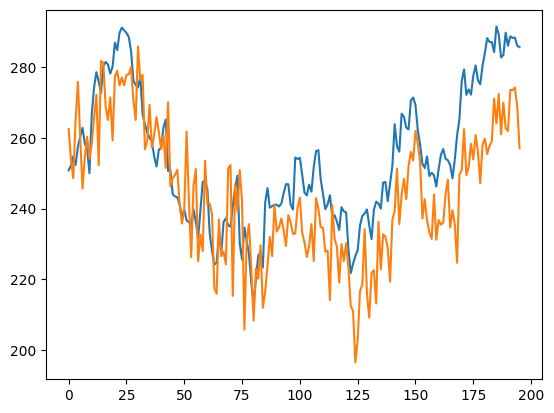

In [4]:
import pickle

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

seq_len, pred_len = 180, 1
seq_len2, pred_len2 = 10, 1
df_train = data.iloc[:int(len(data)*0.7),:]
df_test  = data.iloc[int(len(data)*0.7):,:]

features = 'S'
d_model = 2048
loss_metric = 'mse'

# Standardize manually
scaler = {}
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()
for col in df_train.columns:
    if col != 'date':
        scaler[col] = StandardScaler()
        scaler[col].fit(data[col].values)
        df_train_scaled[col] = scaler[col].transform(df_train[col].values)
        df_test_scaled[col] = scaler[col].transform(df_test[col].values)

model = regressor(
    dataset = df_train_scaled,
    target = target,
    size = [seq_len, pred_len],
    features = features,
    d_model = d_model,
    device = 'cpu'
)

feat_df_train = model.get_features(df_train_scaled).iloc[:-1,:]
feat_df_test = model.get_features(df_test_scaled).iloc[:-1,:]

model = regressor(
    dataset = df_train_scaled,
    target = target,
    size = [seq_len2, pred_len2],
    features = 'MS',
    d_model = 10,
    device = 'cpu'
)
new_col_train = model.get_features(df_train_scaled).iloc[seq_len-seq_len2:-1,:]
new_col_train = new_col_train.drop([target], axis=1)
new_col_train.columns = [f'exog_feat_{i+1}' for i in range(len(new_col_train.columns))]
feat_df_train = pd.concat([feat_df_train, new_col_train], axis=1)

new_col_test = model.get_features(df_test_scaled).iloc[seq_len-seq_len2:-1,:]
new_col_test = new_col_test.drop([target], axis=1)
new_col_test.columns = [f'exog_feat_{i+1}' for i in range(len(new_col_test.columns))]
feat_df_test = pd.concat([feat_df_test, new_col_test], axis=1)

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

params = {
    'objective': 'regression',
    'metric': str(loss_metric),
    'boosting_type': 'gbdt',
    'num_leaves': 10,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': -1,
    'seed': 42
}

X_train, X_test, y_train, y_test = train_test_split(feat_df_train.drop([target], axis=1), feat_df_train[target], test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test)

lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    num_boost_round=2000,
    early_stopping_rounds=50,
    verbose_eval=50
)

s4_ans = df_test[target].iloc[seq_len:]
s4_pred = lgb_model.predict(feat_df_test.drop([target], axis=1))
s4_pred = scaler[target].inverse_transform(s4_pred)

mse = mean_squared_error(s4_ans, s4_pred)
plt.scatter(s4_ans, s4_pred)
plt.show()
plt.plot(s4_ans.values)
plt.plot(s4_pred)
print(f'{loss_metric} : {mse}')

LightGBM自己回帰＋逐次推定

Round 878 / 1253
Round 879 / 1253
Round 880 / 1253
Round 881 / 1253
Round 882 / 1253
Round 883 / 1253
Round 884 / 1253
Round 885 / 1253
Round 886 / 1253
Round 887 / 1253
Round 888 / 1253
Round 889 / 1253
Round 890 / 1253
Round 891 / 1253
Round 892 / 1253
Round 893 / 1253
Round 894 / 1253
Round 895 / 1253
Round 896 / 1253
Round 897 / 1253
Round 898 / 1253
Round 899 / 1253
Round 900 / 1253
Round 901 / 1253
Round 902 / 1253
Round 903 / 1253
Round 904 / 1253
Round 905 / 1253
Round 906 / 1253
Round 907 / 1253
Round 908 / 1253
Round 909 / 1253
Round 910 / 1253
Round 911 / 1253
Round 912 / 1253
Round 913 / 1253
Round 914 / 1253
Round 915 / 1253
Round 916 / 1253
Round 917 / 1253
Round 918 / 1253
Round 919 / 1253
Round 920 / 1253
Round 921 / 1253
Round 922 / 1253
Round 923 / 1253
Round 924 / 1253
Round 925 / 1253
Round 926 / 1253
Round 927 / 1253
Round 928 / 1253
Round 929 / 1253
Round 930 / 1253
Round 931 / 1253
Round 932 / 1253
Round 933 / 1253
Round 934 / 1253
Round 935 / 1253
Round 936 / 12

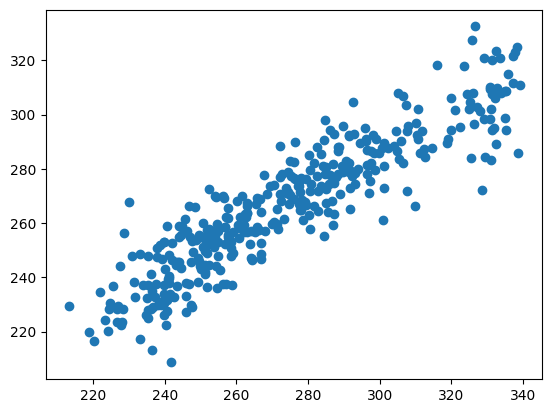

mse : 228.8336503797156


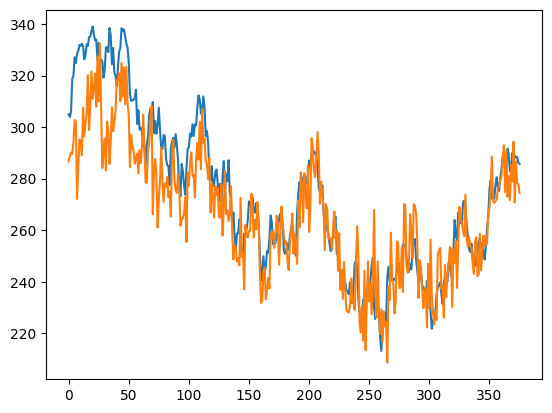

In [9]:
import pickle
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
    
with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

# data = data.iloc[:300,:] # delete

seq_len, pred_len = 180, 1
features = 'S'
d_model = 1024
loss_metric = 'mse'

scaler = {}
for col in data.columns:
    if col != 'date':
        scaler[col] = StandardScaler()
        scaler[col].fit(data[col][:int(len(data)*0.7)])
                
s4_ans_transient = []
s4_pred_transient = []
for i in range(int(len(data)*0.7), len(data)):
    print(f'Round {i+1} / {len(data)}')
    
    df_train = data.iloc[:i,:]
    df_test  = data.iloc[i-seq_len:i,:]

    # Standardize manually
    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()
    for col in df_train.columns:
        if col != 'date':
            df_train_scaled[col] = scaler[col].transform(df_train[col].values)
            df_test_scaled[col] = scaler[col].transform(df_test[col].values)
            
    model = regressor(
        dataset = df_train_scaled,
        target = target,
        size = [seq_len, pred_len],
        features = features,
        d_model = d_model,
        device = 'cpu'
    )

    params = {
        'objective': 'regression',
        'metric': str(loss_metric),
        'boosting_type': 'gbdt',
        'num_leaves': 10, # 31
        'learning_rate': 0.01, # 0.1
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'num_threads': -1,
        'seed': 42,
        'force_col_wise' : True # False
    }

    feat_df = model.get_features(df_train_scaled).iloc[:-1,:]
    X_train, X_test, y_train, y_test = train_test_split(feat_df.drop([target], axis=1), feat_df[target], test_size=0.2, random_state=42)
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_test = lgb.Dataset(X_test, label=y_test)

    lgb_model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
        num_boost_round=2000,
        early_stopping_rounds=50,
        verbose_eval=0
    )

    s4_ans = data[target][i]
    s4_pred_data = model.get_features(df_test_scaled).drop([target], axis=1)
    s4_pred = lgb_model.predict(s4_pred_data)
    s4_pred = scaler[target].inverse_transform(s4_pred)
    s4_pred_transient.append(s4_pred)
    s4_ans_transient.append(s4_ans)
    

mse = mean_squared_error(s4_ans_transient, s4_pred_transient)
plt.scatter(s4_ans_transient, s4_pred_transient)
plt.show()
plt.plot(s4_ans_transient)
plt.plot(s4_pred_transient)
print(f'{loss_metric} : {mse}')

In [3]:
import pickle
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

# data = data.iloc[:300,:] # delete

seq_len, pred_len = 180, 1
seq_len2, pred_len2 = 10, 1
features = 'S'
d_model = 2048
loss_metric = 'mse'

scaler = {}
for col in data.columns:
    if col != 'date':
        scaler[col] = StandardScaler()
        scaler[col].fit(data[col][:int(len(data)*0.7)])
                
s4_ans_transient = []
s4_pred_transient = []
for i in range(int(len(data)*0.7), len(data)):
    print(f'Round {i+1} / {len(data)}')
    
    df_train = data.iloc[:i,:]
    df_test  = data.iloc[i-seq_len:i,:]

    # Standardize manually
    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()
    for col in df_train.columns:
        if col != 'date':
            df_train_scaled[col] = scaler[col].transform(df_train[col].values)
            df_test_scaled[col] = scaler[col].transform(df_test[col].values)
            
    model = regressor(
        dataset = df_train_scaled,
        target = target,
        size = [seq_len, pred_len],
        features = features,
        d_model = d_model,
        device = 'cpu'
    )

    feat_df_train = model.get_features(df_train_scaled).iloc[:-1,:]
    feat_df_test = model.get_features(df_test_scaled)

    model = regressor(
        dataset = df_train_scaled,
        target = target,
        size = [seq_len2, pred_len2],
        features = 'MS',
        d_model = 10,
        device = 'cpu'
    )
    
    new_col_train = model.get_features(df_train_scaled).iloc[seq_len-seq_len2:-1,:]
    new_col_train = new_col_train.drop([target], axis=1)
    new_col_train.columns = [f'exog_feat_{i+1}' for i in range(len(new_col_train.columns))]
    feat_df_train = pd.concat([feat_df_train, new_col_train], axis=1)

    new_col_test = model.get_features(df_test_scaled).iloc[seq_len-seq_len2:,:]
    new_col_test = new_col_test.drop([target], axis=1)
    new_col_test.columns = [f'exog_feat_{i+1}' for i in range(len(new_col_test.columns))]
    feat_df_test = pd.concat([feat_df_test, new_col_test], axis=1)

    params = {
        'objective': 'regression',
        'metric': str(loss_metric),
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'num_threads': -1,
        'seed': 42
    }

    X_train, X_test, y_train, y_test = train_test_split(feat_df_train.drop([target], axis=1), feat_df_train[target], test_size=0.2, random_state=42)
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_test = lgb.Dataset(X_test, label=y_test)

    lgb_model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
        num_boost_round=2000,
        early_stopping_rounds=50,
        verbose_eval=0
    )

    s4_ans = data[target][i]
    s4_pred = lgb_model.predict(feat_df_test.drop([target], axis=1))
    s4_pred = scaler[target].inverse_transform(s4_pred)
    s4_pred_transient.append(s4_pred)
    s4_ans_transient.append(s4_ans)

mse = mean_squared_error(s4_ans_transient, s4_pred_transient)
plt.scatter(s4_ans_transient, s4_pred_transient)
plt.show()
plt.plot(s4_ans_transient)
plt.plot(s4_pred_transient)
print(f'{loss_metric} : {mse}')

6000
Round 878 / 1253


CUDA extension for Cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%
Falling back on slow Cauchy kernel. Install at least one of pykeops or the CUDA extension for memory efficiency.
Falling back on slow Vandermonde kernel. Install pykeops for improved memory efficiency.


Round 879 / 1253
Round 880 / 1253
Round 881 / 1253
Round 882 / 1253
Round 883 / 1253
Round 884 / 1253
Round 885 / 1253
Round 886 / 1253
Round 887 / 1253
Round 888 / 1253
Round 889 / 1253
Round 890 / 1253
Round 891 / 1253
Round 892 / 1253
Round 893 / 1253
Round 894 / 1253
Round 895 / 1253
Round 896 / 1253
Round 897 / 1253
Round 898 / 1253
Round 899 / 1253
Round 900 / 1253
Round 901 / 1253
Round 902 / 1253
Round 903 / 1253
Round 904 / 1253
Round 905 / 1253
Round 906 / 1253
Round 907 / 1253
Round 908 / 1253
Round 909 / 1253
Round 910 / 1253
Round 911 / 1253
Round 912 / 1253
Round 913 / 1253
Round 914 / 1253
Round 915 / 1253
Round 916 / 1253
Round 917 / 1253
Round 918 / 1253
Round 919 / 1253
Round 920 / 1253
Round 921 / 1253
Round 922 / 1253
Round 923 / 1253
Round 924 / 1253
Round 925 / 1253
Round 926 / 1253
Round 927 / 1253
Round 928 / 1253
Round 929 / 1253
Round 930 / 1253
Round 931 / 1253
Round 932 / 1253
Round 933 / 1253
Round 934 / 1253
Round 935 / 1253
Round 936 / 1253
Round 937 / 12

: 

: 

In [10]:
if not os.path.exists('./data'):
    os.makedirs('./data')

def download_stock_data(symbols: List[str], target_symbols: List[str], start_date: str, end_date: str):
    all_symbols = list(symbols + target_symbols)
    data = pd.DataFrame()
    remove_symbols = []
    for symbol in list(set(all_symbols)):
        file_name = f"./data/{symbol}.csv"
        if os.path.isfile(file_name):
            stock_data = pd.read_csv(file_name, index_col=0, parse_dates=True)
            stock_data.index = pd.to_datetime(stock_data.index)
            last_date = stock_data.index[-1]
            if last_date >= pd.Timestamp(datetime.now()):
                new_data = yf.download(symbol, start=last_date.date() + timedelta(days=1), end=end_date, interval='1d')
                if not new_data.empty and pd.isna(new_data['Adj Close'].iloc[-1]):
                    stock_data = stock_data.append(new_data)
                    stock_data = stock_data[~stock_data.index.duplicated(keep='last')]
                    with open(file_name, mode='w') as f:
                        stock_data.to_csv(f)
                else:
                    remove_symbols.append(symbol)
            else:
                pass
        else:
            stock_data = yf.download(symbol, start=start_date, end=end_date, interval='1d')
            if not stock_data.empty and pd.isna(stock_data['Adj Close'].iloc[-1]):
                with open(file_name, mode='w') as f:
                    stock_data.to_csv(f)
            else:
                remove_symbols.append(symbol)
        try:
            data[symbol] = stock_data['Adj Close']
        except Exception as e:
            remove_symbols.append(symbol)
            # print(symbol, e)
            pass
    for item in list(set(remove_symbols)):
        if item in symbols:
            symbols.remove(item)
        if item in target_symbols:
            target_symbols.remove(item)
    with open("./feat_symbols.txt", "w") as f:
        for symbol in symbols:
            f.write(f"{symbol}\n")
    with open("./target_symbols.txt", "w") as f:
        for symbol in target_symbols:
            f.write(f"{symbol}\n")

    return data, symbols, target_symbols

def prepare_data(data, symbols, target_symbols, shift=1):
    prepared_data = {}
    for target_symbol in target_symbols:
        stock_data = pd.DataFrame(data[target_symbol])
        stock_data[f'{target_symbol}_lag_{shift}'] = data[target_symbol].shift(shift, fill_value=0)
        for symbol in symbols:
            if symbol != target_symbol:
                stock_data[f'{symbol}_lag_{shift}'] = data[symbol].shift(shift, fill_value=0)
        prepared_data[target_symbol] = stock_data
    
    for key in prepared_data.keys():
        # shiftの先頭行を排除
        prepared_data[key] = prepared_data[key].iloc[shift:,:]

        # NoneをNaNに置換
        prepared_data[key] = prepared_data[key].replace(to_replace=['None', 'null', 'nan', 'NA'], value=np.nan)

        # 欠損値NaNを過去最新の値で埋める
        prepared_data[key] = prepared_data[key].fillna(method="ffill")
        prepared_data[key] = prepared_data[key].dropna(axis=1)            

        if prepared_data[key].isnull().any().any():
            st.write(f"{key} : NaN values found.")
    
    return prepared_data

def feature_selection(X, y):
    rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
    feature_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
    feature_selector.fit(X.values, y.values.ravel())
    selected_features = X.columns[feature_selector.support_].tolist()
    return selected_features

def load_selected_features(target_symbol, lag):
    file_name = f"./feature_selection/{target_symbol}_lag{lag}_selected_features.txt"
    if os.path.isfile(file_name):
        with open(file_name, "r") as f:
            selected_features = [line.strip() for line in f.readlines()]
        return selected_features
    return None

def save_selected_features(target_symbol, selected_features, lag):
    file_name = f"./feature_selection/{target_symbol}_lag{lag}_selected_features.txt"
    with open(file_name, "w") as f:
        for feature in selected_features:
            f.write(f"{feature}\n")
            
def train_and_test(data, symbols, target_symbols, original_data, future_days=1):
    predictions = {}
    actuals = {}
    future_predictions = {}

    for target_symbol in target_symbols:
        X = data[target_symbol].drop([target_symbol], axis=1)
        y = data[target_symbol][target_symbol]

        # Perform feature selection using Boruta
        selected_features = load_selected_features(target_symbol, future_days)
        if not selected_features:
            selected_features = feature_selection(X, y)
            save_selected_features(target_symbol, selected_features, future_days)
        
        X = X[selected_features]
        X[target_symbol] = y

        # Split data for final evaluation
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        _y_train, y_test = y[:train_size], y[train_size:]
        
        # Initialize the Autogluon TabularPredictor
        predictor = TabularPredictor(label=target_symbol, path=f'C:/Users/rodin/work/stock_trade/', problem_type='regression')

        # Fit the model with cross-validation and excluding CatBoost
        predictor.fit(train_data=X_train, presets='best_quality', time_limit=60)

        predictions[target_symbol] = pd.DataFrame(predictor.predict(X_test).values, index=y_test.index, columns=["prediction"])

        actuals[target_symbol] = pd.DataFrame(y_test.values, index=y_test.index, columns=["actual"])

        future_dates = [data[target_symbol].index[-1] + timedelta(days=i) for i in range(1, future_days + 1)]

        # Initialize future_df with columns for all symbols
        future_df = pd.DataFrame(index=future_dates, columns=X.columns).drop([target_symbol], axis=1)

        for column in future_df.columns:
            symbol, _, lag = column.split('_')
            lag = int(lag)
            future_df.loc[:, column] = original_data[symbol].iloc[-lag:].values
    
        # Predict future prices for the target symbol and save the results
        future_predictions[target_symbol] = pd.DataFrame(predictor.predict(future_df[selected_features]).values, index=future_dates[:len(future_df)], columns=["prediction"])

    return predictions, actuals, future_predictions

def algo_trade(symbols, target_symbols, years, shift):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=years*365)
    data, symbols, target_symbols = download_stock_data(symbols, target_symbols, start_date, end_date)
    original_data = copy.deepcopy(data)
    prepared_data = prepare_data(data, symbols, target_symbols, shift=shift)
    
    predictions, actuals, future_predictions = train_and_test(prepared_data, symbols, target_symbols, original_data, future_days=shift)

    return predictions, actuals, future_predictions


In [3]:
# 銘柄リストを取得する関数
def get_symbol_list(file):
    with open(file, "r") as f:
        symbols = [line.strip() for line in f.readlines()]
    return symbols
    
# スクレイピングを行う関数
def get_stock_info():
    stock_table, balance = get_sbi_holdings(username, password)
    asset = round(stock_table["評価額"].sum()/10000)
    balance = round(balance/10000)
    return stock_table, asset, balance

# スクレイピングしたデータをキャッシュする
def cached_data():
    return get_stock_info()

def fetch_data(symbols, interval, start_date, end_date):
    data = {}
    for symbol in symbols:
        stock_data = yf.download(symbol, start=start_date, end=end_date, interval=interval)
        data[symbol] = stock_data
    return data

def display_charts(data, symbols, interval):
    for symbol in symbols:
        st.subheader(f"{symbol} {interval} Chart")

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=data[symbol].index, y=data[symbol]['Close'],
                    mode='lines',
                    name='Close Price'))
        fig.update_layout(
            title=f"{symbol} {interval} Chart",
            xaxis_title="Date",
            yaxis_title="Close Price"
        )

        st.plotly_chart(fig)

def calculate_mape(actuals, predictions):
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    return mape

def display_prediction(target_symbols, predictions, actuals, future_predictions):
    # クロスバリデーションのもっともよかったモデルの予測と実績の対比と、
    # 一週間分の将来予測を時系列グラフにして表示
    for target_symbol in target_symbols:
        # 時系列プロットとy-yプロットのカラムを作成

        # 時系列プロット
        fig = go.Figure()

        # 時系列プロットの幅を900に設定
        fig.update_layout(width=850)

        fig.add_trace(go.Scatter(x=actuals[target_symbol].index,
                                y=actuals[target_symbol]['actual'],
                                mode='lines',
                                name='Actual',
                                line=dict(color='black')))
        fig.add_trace(go.Scatter(x=predictions[target_symbol].index,
                                y=predictions[target_symbol]['prediction'],
                                mode='lines',
                                name='Predicted',
                                line=dict(color='red', dash='3px,2px', width=1.4)))

        # Add future predictions to the plot
        future_dates = future_predictions[target_symbol].index
        fig.add_trace(go.Scatter(x=future_dates,
                                y=future_predictions[target_symbol]['prediction'],
                                mode='lines',
                                name='Forecasted',
                                line=dict(color='green', dash='3px,2px', width=1.4)))

        fig.update_layout(title=f"{target_symbol} Predictions vs Actuals vs Forecasted",
                        xaxis_title="Date",
                        yaxis_title="Close Price")

        # y-yプロット
        fig_yy = go.Figure()

        # y-yプロットの幅を300に設定
        fig_yy.update_layout(width=350)

        fig_yy.add_trace(go.Scatter(x=actuals[target_symbol]['actual'],
                                    y=predictions[target_symbol]['prediction'],
                                    mode='markers',
                                    name='Predicted vs Actual',
                                    marker=dict(color='blue', size=5)))

        # y=yの点線を追加
        fig_yy.add_shape(
            type='line',
            x0=min(actuals[target_symbol]['actual']),
            x1=max(actuals[target_symbol]['actual']),
            y0=min(actuals[target_symbol]['actual']),
            y1=max(actuals[target_symbol]['actual']),
            yref='y',
            xref='x',
            line=dict(color='black', dash='dot')
        )

        # MAPEの計算
        mape = calculate_mape(actuals[target_symbol]['actual'], predictions[target_symbol]['prediction'])

        fig_yy.update_layout(title=f"{target_symbol} Y-Y Plot (MAPE: {mape:.2f}%)",
                            xaxis_title="Actual",
                            yaxis_title="Predicted")
        fig.show()

In [133]:
years = 5 # 学習データの期間
shift = 5 # n 期先予測

symbols = get_symbol_list("feat_symbols.txt")
target_symbols = get_symbol_list("target_symbols.txt")

predictions, actuals, future_predictions = algo_trade(symbols, target_symbols, years, shift)

C:\Users\rodin\AppData\Local\Temp\ipykernel_22952\1505525427.py:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\rodin\AppData\Local\Temp\ipykernel_22952\1505525427.py:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\rodin\AppData\Local\Temp\ipykernel_22952\1505525427.py:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragment

In [134]:
display(predictions)
display(actuals)
display(future_predictions)

{'4584.T':             prediction
 Date                  
 2022-04-22  466.021271
 2022-04-25  462.821228
 2022-04-26  457.203979
 2022-04-27  470.194519
 2022-04-28  471.487915
 ...                ...
 2023-04-17  589.687744
 2023-04-18  596.604553
 2023-04-19  601.088257
 2023-04-20  601.071960
 2023-04-21  600.390015
 
 [251 rows x 1 columns],
 '1557.T':               prediction
 Date                    
 2022-04-22  56271.507812
 2022-04-25  56090.335938
 2022-04-26  55976.402344
 2022-04-27  55956.234375
 2022-04-28  55515.574219
 ...                  ...
 2023-04-17  47400.000000
 2023-04-18  48552.910156
 2023-04-19  48492.324219
 2023-04-20  48840.617188
 2023-04-21  48394.453125
 
 [251 rows x 1 columns],
 '8789.T':             prediction
 Date                  
 2022-04-22   43.185486
 2022-04-25   42.719479
 2022-04-26   43.433487
 2022-04-27   43.614517
 2022-04-28   43.143738
 ...                ...
 2023-04-17   62.194145
 2023-04-18   63.224930
 2023-04-19   63.114830
 2

{'4584.T':             actual
 Date              
 2022-04-22   469.0
 2022-04-25   464.0
 2022-04-26   458.0
 2022-04-27   438.0
 2022-04-28   467.0
 ...            ...
 2023-04-17   249.0
 2023-04-18   254.0
 2023-04-19   253.0
 2023-04-20   251.0
 2023-04-21   244.0
 
 [251 rows x 1 columns],
 '1557.T':              actual
 Date               
 2022-04-22  55950.0
 2022-04-25  54320.0
 2022-04-26  54940.0
 2022-04-27  53450.0
 2022-04-28  54730.0
 ...             ...
 2023-04-17  55370.0
 2023-04-18  55640.0
 2023-04-19  55630.0
 2023-04-20  55640.0
 2023-04-21  55080.0
 
 [251 rows x 1 columns],
 '8789.T':             actual
 Date              
 2022-04-22    42.0
 2022-04-25    41.0
 2022-04-26    43.0
 2022-04-27    41.0
 2022-04-28    42.0
 ...            ...
 2023-04-17    65.0
 2023-04-18    67.0
 2023-04-19    67.0
 2023-04-20    67.0
 2023-04-21    69.0
 
 [251 rows x 1 columns],
 '1893.T':                 actual
 Date                  
 2022-04-22  614.297241
 2022-04-25  5

{'4584.T':             prediction
 2023-04-22  599.554871
 2023-04-23  602.644409
 2023-04-24  603.763489
 2023-04-25  607.525696
 2023-04-26  607.986572,
 '1557.T':               prediction
 2023-04-22  49160.675781
 2023-04-23  48538.625000
 2023-04-24  48417.152344
 2023-04-25  48564.863281
 2023-04-26  48074.449219,
 '8789.T':             prediction
 2023-04-22   64.283302
 2023-04-23   64.718216
 2023-04-24   64.687721
 2023-04-25   64.843407
 2023-04-26   64.916779,
 '1893.T':             prediction
 2023-04-22  665.432678
 2023-04-23  667.104797
 2023-04-24  665.367859
 2023-04-25  664.172058
 2023-04-26  666.226624,
 'MSFT':             prediction
 2023-04-22  241.574600
 2023-04-23  241.755371
 2023-04-24  240.824188
 2023-04-25  239.534119
 2023-04-26  239.983749}

In [135]:
display_prediction(target_symbols, predictions, actuals, future_predictions)